1.导入数据包和数据集

In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'./train.csv')
test = pd.read_csv(r'test.csv')
PassengerId = test['PassengerId']
all_data = pd.concat([train, test], ignore_index=True) # 连接

2.总体概览

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


３．初步分析，绘图

In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

(1)女性幸存率远高于男性

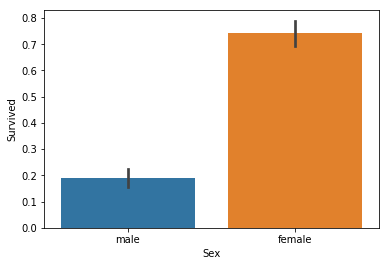

In [5]:
sns.barplot(x="Sex", y="Survived", data=train)

(2)乘客社会等级越高，幸存率越高

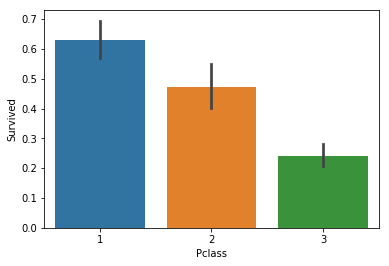

In [6]:
sns.barplot(x="Pclass", y="Survived", data=train)

(3)配偶及兄弟姐妹数适中的乘客幸存率越高

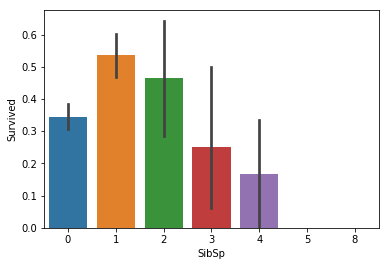

In [7]:
sns.barplot(x="SibSp", y="Survived", data=train)

(4)父母与子女数适中的乘客幸存率越高

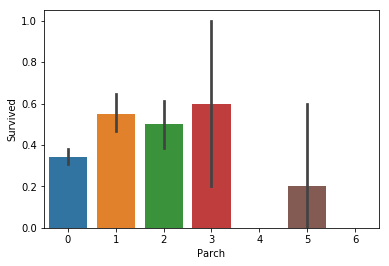

In [8]:
sns.barplot(x="Parch", y="Survived", data=train)

(5)查看年龄与幸存率之间的关系

Text(12.359751157407416, 0.5, 'density')

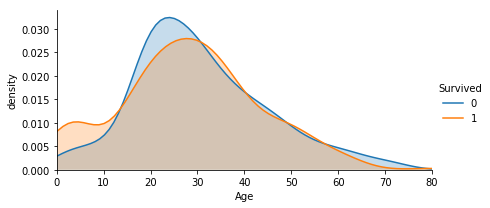

In [9]:
facet = sns.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", shade=True)  # 核密度估计图
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

(6)登录港口与生存情况分析，C地登录的生存率更高，需保留这个特征

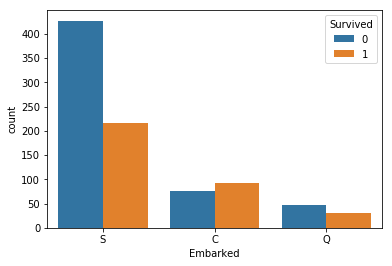

In [10]:
sns.countplot('Embarked', hue='Survived', data=train)

(7)不同称称呼的乘客幸存率
新增Title特征，从姓名中提取乘客的称呼，归纳为６类

In [11]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master', 'Jonkheer'], 'Master'))

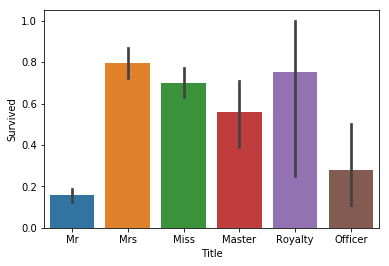

In [12]:
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x='Title', y='Survived', data=all_data)

(8)新增FamilyLbel特征，计算FamilySize = Parch+SibSp+1,然后分三类

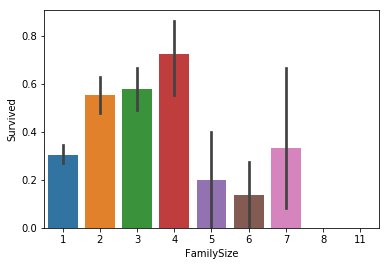

In [13]:
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x='FamilySize', y='Survived', data=all_data)

(8)-1:按生存率将FamilySize分为三类，构成其特征

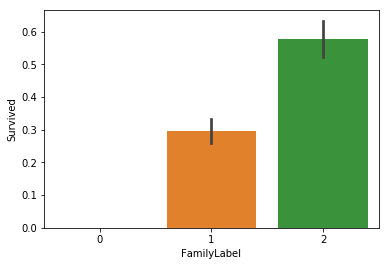

In [14]:
def Fam_label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=7)) | (s==1):
        return 1
    elif s>7:
        return 0

all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)
sns.barplot(x='FamilyLabel', y='Survived', data=all_data)

(9)不同甲板的乘客幸存率不同

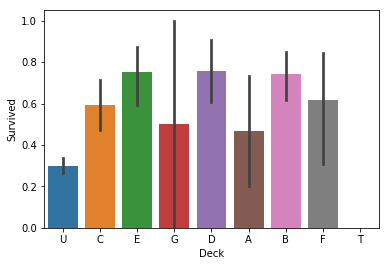

In [15]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x='Deck', y='Survived', data=all_data)

(10)票号与生存与否

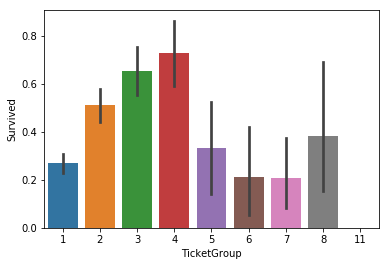

In [16]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x="TicketGroup", y="Survived", data=all_data)

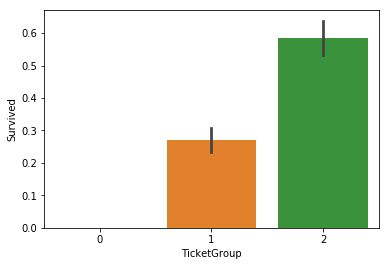

In [17]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s>8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

3.数据清洗

1)缺失值填充，用sex\title\pclass构建随机森林模型，填充年龄缺失值

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
age_df = all_data[['Age', 'Pclass', 'Sex', 'Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges

In [21]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


缺失值２个，且票价和等级一致，取该票价和该等级的中位数填充

In [22]:
all_data.groupby(by=['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [23]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

FareFeature特征缺失１，　用Embarked为S, Pclass为３的乘客的Fare中位数填充

In [25]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [27]:
fare = all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

2)同组识别

把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性

In [30]:
all_data['Surname'] = all_data['Name'].apply(lambda x: x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x: Surname_Count[x])
Female_Child_Group = all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age'] <= 12) | (all_data['Sex'] == 'female'))]
Male_Adult_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & (all_data['Age'] > 12) & (all_data['Sex'] == 'male')]

In [33]:
Female_Child = pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns = ['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

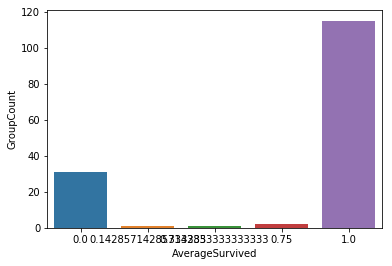

In [34]:
sns.barplot(x=Female_Child.index, y=Female_Child['GroupCount']).set_xlabel('AverageSurvived')

绝大部分成年男性组平均存活率为１或０

In [35]:
Male_Adult = pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns = ['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


普遍规律是女性和儿童的幸存率高，成年男性的幸存率低，　所以我们把不符合普遍规律的反常组选出来单独处理．把女性和儿童组中幸存率为０的组设置为遇难组，把成年男性组中存活率为１的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的男性幸存的可能性较高

In [36]:
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List = set(Female_Child_Group[Female_Child_Group.apply(lambda x: x==0)].index)
print(Dead_List)
Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List = set(Male_Adult_List[Male_Adult_List.apply(lambda x: x==1)].index)
print(Survived_List)

{'Rice', 'Attalah', 'Ford', 'Jussila', 'Oreskovic', 'Rosblom', 'Vander Planke', 'Panula', 'Lefebre', 'Lobb', 'Robins', 'Van Impe', 'Skoog', 'Turpin', 'Bourke', 'Johnston', 'Strom', 'Danbom', 'Boulos', 'Olsson', 'Arnold-Franchi', 'Canavan', 'Zabour', 'Cacic', 'Palsson', 'Sage', 'Goodwin', 'Barbara', 'Caram', 'Ilmakangas', 'Lahtinen'}
{'Taylor', 'Goldenberg', 'Bradley', 'Frolicher-Stehli', 'Bishop', 'Greenfield', 'Kimball', 'Harder', 'Beane', 'McCoy', 'Nakid', 'Daly', 'Jussila', 'Dick', 'Duff Gordon', 'Beckwith', 'Cardeza', 'Jonsson', 'Chambers', 'Frauenthal'}


为了使处于这两种反常组中的样本能够被正确分类，对测试集中的反常组中的样本Age, Title, Sex进行惩罚修改

In [ ]:
train = all_data.loc[all_data['Survived'].notnull()]
test = all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Age'] = '60'
test.loc[(test['Surname'].apply(lambda x: x in Dead_List)), 'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x: x in Survived_List)), 'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x: x in Survived_List)), 'Age'] = '5'
test.loc[(test['Surname'].apply(lambda x: x in Survived_List)), 'Title'] = 'Miss'

3)特征转换

In [39]:
all_data = pd.concat([train, test])
all_data = all_data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilyLabel', 'Deck', 'TicketGroup']]
all_data = pd.get_dummies(all_data)
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived', axis=1)
X = train.as_matrix()[:, 1:]
y = train.as_matrix()[:, 0]

4)建模和优化

４)-1参数优化，　用网格搜索自动化选取最优参数

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [44]:
pipe = Pipeline([('select', SelectKBest(k=20)), 
                 ('classify', RandomForestClassifier(random_state=10, max_features='sqrt'))])
param_test = {'classify__n_estimators': list(range(20, 50, 2)), 
              'classify__max_depth': list(range(3, 60, 3))}
gsearch = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

KeyboardInterrupt: 

4)-2训练模型

In [45]:
from sklearn.pipeline import make_pipeline

In [53]:
select = SelectKBest(k=20)
clf = RandomForestClassifier(random_state=10, warm_start=True,
                            n_estimators=26, 
                            max_depth=6,
                            max_features='sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x7efc60a8a510>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0....imators=26, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

4)-3交叉验证

In [49]:
from sklearn.model_selection import cross_val_score

In [54]:
cv_score = cross_val_score(pipeline, X, y, cv=10)
print("CV Score: Mean - %.7g | Std - %.7g"%(np.mean(cv_score), np.std(cv_score)))

CV Score: Mean - 0.8339295 | Std - 0.04002523


5)预测

In [55]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({'PassengerId': PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv(r"./submission1.csv", index=False)